# Starter Notebook

Install and import required libraries

In [1]:
#!/usr/bin/env python
"""
End-to-End Script: Fine-Tuning RoBERTa with Aggressive Top-Layer LoRA Injection
for AGNEWS text classification.

This script:
1. Loads the AGNEWS dataset.
2. Tokenizes the texts.
3. Loads a pre-trained RoBERTa model for sequence classification.
4. Configures LoRA to inject into only the top layers (last 4 transformer blocks)
   using aggressive settings.
5. Sets up training via Hugging Face Trainer.
6. Evaluates the model and optionally runs inference.

Author: [Your Name]
Date: [Today's Date]
"""

import os
import pandas as pd
import torch
from transformers import RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


In [ ]:

# -------------------------------
# Load Dataset and Tokenizer
# -------------------------------

base_model = 'roberta-base'
print("Loading AGNEWS dataset...")
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

print("Tokenizing dataset...")
tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Extract label information for later use
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"Number of labels: {num_labels}")
print(f"Label names: {class_names}")
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# -------------------------------
# Load Pre-trained RoBERTa Model
# -------------------------------

print("Loading RoBERTa model for sequence classification...")
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label,
    num_labels=num_labels
)

# -------------------------------
# Split the Dataset
# -------------------------------

# We split off a small portion for evaluation
print("Splitting dataset into training and evaluation sets...")
split_datasets = tokenized_dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']


In [2]:
from datasets import load_dataset
from transformers import RobertaTokenizer, DataCollatorWithPadding

base_model = "roberta-base"
tokenizer  = RobertaTokenizer.from_pretrained(base_model)

# ① 一次性把 train 和 test 都加载出来
dataset = load_dataset("ag_news")            # -> dict 里有 "train" 和 "test"

# ② 预处理函数保持不变
def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

# ③ 分别 tokenize ；注意要把 "label" 重命名成 "labels"
train_dataset = (
    dataset["train"]
    .map(preprocess, batched=True, remove_columns=["text"])
    .rename_column("label", "labels")
)

eval_dataset = (
    dataset["test"]        # 7 600 条
    .map(preprocess, batched=True, remove_columns=["text"])
    .rename_column("label", "labels")
)

print("Train size:", len(train_dataset))   # 120000
print("eval  size:", len(eval_dataset))    # 7600

# ④ 其它部分（id2label、data_collator、模型、LoRA、Trainer…）与之前相同
num_labels  = dataset["train"].features["label"].num_classes
class_names = dataset["train"].features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

print("Loading RoBERTa model for sequence classification...")
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label,
    num_labels=num_labels
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train size: 120000
eval  size: 7600
Loading RoBERTa model for sequence classification...


In [ ]:
from peft import LoraConfig, get_peft_model


rank_schedule = {8: 5, 9: 8, 10: 16, 11: 20}

target_modules = []
rank_pattern   = {}
alpha_pattern  = {}

for layer, r_i in rank_schedule.items():
    a_i = 2*r_i                        # keep α / r ≈ 1
    # ─── Attention projections ───
    for proj in ["query",  "value"]:
        name = f"roberta.encoder.layer.{layer}.attention.self.{proj}"
        target_modules.append(name)
        rank_pattern[name]  = r_i
        alpha_pattern[name] = a_i
    # ─── Feed‑forward linear layers ───
    if layer >= 11:
        for proj in ["intermediate.dense", "output.dense"]:
            name = f"roberta.encoder.layer.{layer}.{proj}"
            target_modules.append(name)
            rank_pattern[name]  = r_i
            alpha_pattern[name] = a_i

# A scalar fallback is still required but will be ignored because of the patterns
peft_config = LoraConfig(
    r=max(rank_schedule.values()),
    lora_alpha=max(rank_schedule.values()),
    lora_dropout=0.1,
    bias="all",
    target_modules=target_modules,
    rank_pattern=rank_pattern,
    alpha_pattern=alpha_pattern,
    task_type="SEQ_CLS",
)

print("Injecting adapters …")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()


Injecting adapters …
trainable params: 999,940 || all params: 125,546,504 || trainable%: 0.7965


In [4]:
from transformers import EarlyStoppingCallback
# -------------------------------
# Training Setup
# -------------------------------
# Define evaluation metrics.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

output_dir = "results"

# To address CUDA memory issues, reduce the batch sizes.
# Optionally, use gradient_accumulation_steps to achieve a larger effective batch size
# without increasing per-device memory usage.


training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="tensorboard",
    logging_steps=500, 
    logging_dir="logs",

    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    # metric_for_best_model="accuracy",
    # greater_is_better=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    learning_rate=5e-4,
    num_train_epochs=30,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    optim="adamw_torch",
    weight_decay=0.0,
    # warmup_steps=300,
    label_smoothing_factor=0.05,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    
    fp16=True,
    dataloader_num_workers=10,
)




def get_trainer(model):
    return Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
    )

print("Setting up the Trainer...")
trainer = get_trainer(peft_model)

# -------------------------------
# Training the Model
# -------------------------------

print("Starting training...")
train_result = trainer.train()
trainer.save_model()  # Saves the adapter weights
print("Training finished!")

# -------------------------------
# Evaluation
# -------------------------------

print("Evaluating model...")
eval_result = trainer.evaluate()
print("Evaluation Metrics:", eval_result)


print("Saving best-performing model...")
trainer.model.save_pretrained("best_adapter")
tokenizer.save_pretrained("best_adapter")



No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Setting up the Trainer...
Starting training...


Step,Training Loss,Validation Loss,Accuracy
500,0.897100,0.433288,0.904342
1000,0.421500,0.396379,0.915921
1500,0.391700,0.383217,0.924079
2000,0.383000,0.370615,0.929737
2500,0.371000,0.370736,0.928816
3000,0.361100,0.357693,0.933684
3500,0.361500,0.356540,0.933816
4000,0.359900,0.350407,0.935263
4500,0.352700,0.349851,0.938026
5000,0.352400,0.370636,0.927895


Training finished!
Evaluating model...


Evaluation Metrics: {'eval_loss': 0.32530900835990906, 'eval_accuracy': 0.9484210526315789, 'eval_runtime': 5.3149, 'eval_samples_per_second': 1429.955, 'eval_steps_per_second': 44.78, 'epoch': 9.333333333333334}
Saving best-performing model...


('best_adapter/tokenizer_config.json',
 'best_adapter/special_tokens_map.json',
 'best_adapter/vocab.json',
 'best_adapter/merges.txt',
 'best_adapter/added_tokens.json')

In [5]:
# -------------------------------
# Optional: Inference on Eval Dataset
# -------------------------------
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.
    Returns metrics and predictions if labelled=True, else predictions.
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inference_model.to(device)
    inference_model.eval()
    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())
        if labelled:
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    all_predictions = torch.cat(all_predictions, dim=0)
    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

# Run evaluation on the eval_dataset (with labels)
print("Performing final evaluation on eval_dataset...")

final_metrics,_ = evaluate_model(peft_model, eval_dataset, labelled=True, batch_size=32, data_collator=data_collator)

print(final_metrics)






Performing final evaluation on eval_dataset...


Evaluating: 100%|██████████| 238/238 [00:06<00:00, 38.91it/s]

Evaluation Metric: {'accuracy': 0.9484210526315789}
{'accuracy': 0.9484210526315789}


In [6]:



# -------------------------------
# Optional: Inference on an Unlabelled Dataset
# -------------------------------
# Load an unlabelled dataset (example using pickle), tokenize, and run inference.
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])



from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# 加载 adapter 的 config
config = PeftConfig.from_pretrained("best_adapter")

# 加载 base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=4  # ✅ 必须与训练时一致
)
# 加载最佳 adapter 权重
best_model = PeftModel.from_pretrained(base_model, "best_adapter")

# 推理时使用这个模型
preds = evaluate_model(best_model, test_dataset, labelled=False, batch_size=32, data_collator=data_collator)

# preds = evaluate_model(peft_model, test_dataset, labelled=False, batch_size=32, data_collator=data_collator)
# Save predictions to CSV.
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir, "inference_output_J5.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

if __name__ == "__main__":
    print("Finished all steps. You can now run inference or further analysis as needed.")

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 250/250 [00:16<00:00, 15.32it/s]

Inference complete. Predictions saved to inference_output.csv
Finished all steps. You can now run inference or further analysis as needed.


In [7]:
import gc, os, shutil, torch
from transformers import set_seed

# ── 1. 清理 GPU / CPU 内存 ────────────────────────────────
torch.cuda.empty_cache()
gc.collect()

# ── 2. 删除旧对象（保险做法）──────────────────────────────
for var in ["model", "trainer"]:
    if var in globals():
        del globals()[var]
gc.collect(); torch.cuda.empty_cache()




In [8]:
#!/usr/bin/env python
"""
End-to-End Script: Fine-Tuning RoBERTa with Aggressive Top-Layer LoRA Injection
for AGNEWS text classification.

This script:
1. Loads the AGNEWS dataset.
2. Tokenizes the texts.
3. Loads a pre-trained RoBERTa model for sequence classification.
4. Configures LoRA to inject into only the top layers (last 4 transformer blocks)
   using aggressive settings.
5. Sets up training via Hugging Face Trainer.
6. Evaluates the model and optionally runs inference.

Author: [Your Name]
Date: [Today's Date]
"""

import os
import pandas as pd
import torch
from transformers import RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# -------------------------------
# Load Dataset and Tokenizer
# -------------------------------


base_model = "roberta-base"
tokenizer  = RobertaTokenizer.from_pretrained(base_model)

# ① 一次性把 train 和 test 都加载出来
dataset = load_dataset("ag_news")            # -> dict 里有 "train" 和 "test"

# ② 预处理函数保持不变
def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

# ③ 分别 tokenize ；注意要把 "label" 重命名成 "labels"
train_dataset = (
    dataset["train"]
    .map(preprocess, batched=True, remove_columns=["text"])
    .rename_column("label", "labels")
)

eval_dataset = (
    dataset["test"]        # 7 600 条
    .map(preprocess, batched=True, remove_columns=["text"])
    .rename_column("label", "labels")
)

print("Train size:", len(train_dataset))   # 120000
print("eval  size:", len(eval_dataset))    # 7600

# ④ 其它部分（id2label、data_collator、模型、LoRA、Trainer…）与之前相同
num_labels  = dataset["train"].features["label"].num_classes
class_names = dataset["train"].features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

print("Loading RoBERTa model for sequence classification...")
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label,
    num_labels=num_labels
)



Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train size: 120000
eval  size: 7600
Loading RoBERTa model for sequence classification...


In [20]:
from peft import LoraConfig, get_peft_model

rank_schedule = {8: 17, 9: 18, 10: 32, 11: 32}

target_modules = []
rank_pattern   = {}
alpha_pattern  = {}

for layer, r_i in rank_schedule.items():
    a_i = 2*r_i                        # keep α / r ≈ 1
    # ─── Attention projections ───
    for proj in ["query",  "value"]:
        name = f"roberta.encoder.layer.{layer}.attention.self.{proj}"
        target_modules.append(name)
        rank_pattern[name]  = r_i
        alpha_pattern[name] = a_i
    # ─── Feed‑forward linear layers ───
    # if layer >= 11:
    #     for proj in ["intermediate.dense", "output.dense"]:
    #         name = f"roberta.encoder.layer.{layer}.{proj}"
    #         target_modules.append(name)
    #         rank_pattern[name]  = r_i
    #         alpha_pattern[name] = a_i

# A scalar fallback is still required but will be ignored because of the patterns
peft_config = LoraConfig(
    r=max(rank_schedule.values()),
    lora_alpha=max(rank_schedule.values()),
    lora_dropout=0.1,
    bias="all",
    target_modules=target_modules,
    rank_pattern=rank_pattern,
    alpha_pattern=alpha_pattern,
    task_type="SEQ_CLS",
)

print("Injecting adapters …")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()


Injecting adapters …
trainable params: 999,940 || all params: 125,546,504 || trainable%: 0.7965


In [ ]:
from transformers import EarlyStoppingCallback
# -------------------------------
# Training Setup
# -------------------------------
# Define evaluation metrics.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

output_dir = "results"

# To address CUDA memory issues, reduce the batch sizes.
# Optionally, use gradient_accumulation_steps to achieve a larger effective batch size
# without increasing per-device memory usage.


training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="tensorboard",
    logging_steps=500, 
    logging_dir="logs",

    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    # metric_for_best_model="accuracy",
    # greater_is_better=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    learning_rate=5e-4,
    num_train_epochs=30,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,

    optim="adamw_torch",
    weight_decay=0.0,
    # warmup_steps=300,
    label_smoothing_factor=0.05,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    
    fp16=True,
    dataloader_num_workers=10,
)




def get_trainer(model):
    return Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
    )

print("Setting up the Trainer...")
trainer = get_trainer(peft_model)

# -------------------------------
# Training the Model
# -------------------------------

print("Starting training...")
train_result = trainer.train()
trainer.save_model()  # Saves the adapter weights
print("Training finished!")

# -------------------------------
# Evaluation
# -------------------------------

print("Evaluating model...")
eval_result = trainer.evaluate()
print("Evaluation Metrics:", eval_result)


print("Saving best-performing model...")
trainer.model.save_pretrained("best_adapter")
tokenizer.save_pretrained("best_adapter")



No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Setting up the Trainer...
Starting training...


Step,Training Loss,Validation Loss,Accuracy
500,0.624600,0.381132,0.924342
1000,0.373300,0.362190,0.931842
1500,0.354500,0.353953,0.935000
2000,0.343900,0.337108,0.942632
2500,0.331600,0.329669,0.944868
3000,0.323900,0.338008,0.942237
3500,0.319200,0.328734,0.947368
4000,0.313200,0.344115,0.941711
4500,0.309200,0.324593,0.947500
5000,0.302600,0.323592,0.949605


Training finished!
Evaluating model...


Evaluation Metrics: {'eval_loss': 0.3235924541950226, 'eval_accuracy': 0.9496052631578947, 'eval_runtime': 5.0951, 'eval_samples_per_second': 1491.636, 'eval_steps_per_second': 23.356, 'epoch': 19.189866666666667}
Saving best-performing model...


('best_adapter/tokenizer_config.json',
 'best_adapter/special_tokens_map.json',
 'best_adapter/vocab.json',
 'best_adapter/merges.txt',
 'best_adapter/added_tokens.json')

In [22]:
# -------------------------------
# Optional: Inference on Eval Dataset
# -------------------------------
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.
    Returns metrics and predictions if labelled=True, else predictions.
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inference_model.to(device)
    inference_model.eval()
    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())
        if labelled:
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    all_predictions = torch.cat(all_predictions, dim=0)
    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

# Run evaluation on the eval_dataset (with labels)
print("Performing final evaluation on eval_dataset...")

final_metrics,_ = evaluate_model(peft_model, eval_dataset, labelled=True, batch_size=32, data_collator=data_collator)

print(final_metrics)






Performing final evaluation on eval_dataset...


Evaluating: 100%|██████████| 238/238 [00:05<00:00, 40.18it/s]

Evaluation Metric: {'accuracy': 0.9496052631578947}
{'accuracy': 0.9496052631578947}


In [23]:



# -------------------------------
# Optional: Inference on an Unlabelled Dataset
# -------------------------------
# Load an unlabelled dataset (example using pickle), tokenize, and run inference.
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])



from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# 加载 adapter 的 config
config = PeftConfig.from_pretrained("best_adapter")

# 加载 base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path,
    num_labels=4  # ✅ 必须与训练时一致
)
# 加载最佳 adapter 权重
best_model = PeftModel.from_pretrained(base_model, "best_adapter")

# 推理时使用这个模型
preds = evaluate_model(best_model, test_dataset, labelled=False, batch_size=32, data_collator=data_collator)

# preds = evaluate_model(peft_model, test_dataset, labelled=False, batch_size=32, data_collator=data_collator)
# Save predictions to CSV.
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir, "inference_output_J6.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

if __name__ == "__main__":
    print("Finished all steps. You can now run inference or further analysis as needed.")

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 250/250 [00:16<00:00, 15.60it/s]

Inference complete. Predictions saved to inference_output.csv
Finished all steps. You can now run inference or further analysis as needed.


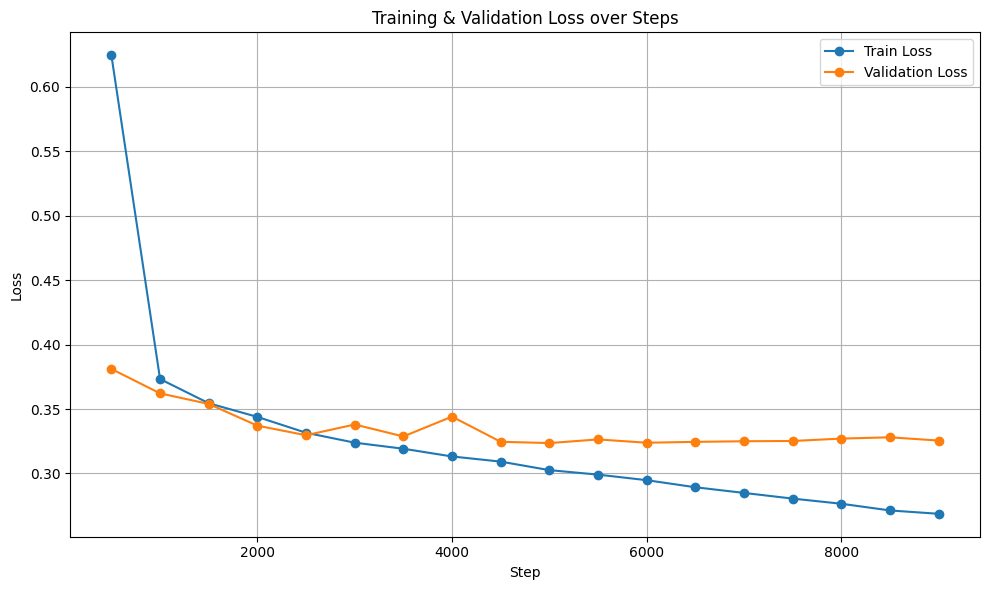

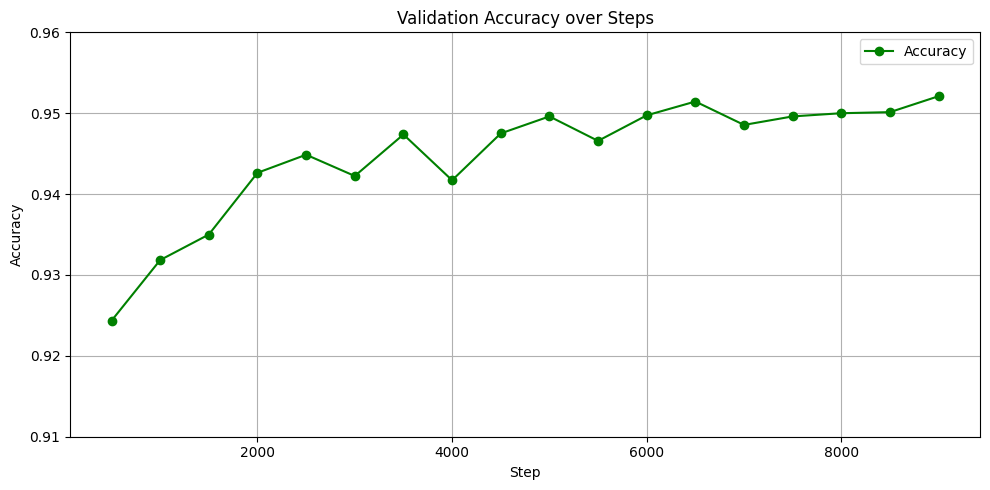

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# 你的训练过程中的记录（建议直接复制粘贴或者从 log 自动提取）
data = [
    [500, 0.624600, 0.381132, 0.924342],
    [1000, 0.373300, 0.362190, 0.931842],
    [1500, 0.354500, 0.353953, 0.935000],
    [2000, 0.343900, 0.337108, 0.942632],
    [2500, 0.331600, 0.329669, 0.944868],
    [3000, 0.323900, 0.338008, 0.942237],
    [3500, 0.319200, 0.328734, 0.947368],
    [4000, 0.313200, 0.344115, 0.941711],
    [4500, 0.309200, 0.324593, 0.947500],
    [5000, 0.302600, 0.323592, 0.949605],
    [5500, 0.299100, 0.326430, 0.946579],
    [6000, 0.294800, 0.323859, 0.949737],
    [6500, 0.289300, 0.324530, 0.951447],
    [7000, 0.284900, 0.325003, 0.948553],
    [7500, 0.280500, 0.325228, 0.949605],
    [8000, 0.276500, 0.327072, 0.950000],
    [8500, 0.271300, 0.328078, 0.950132],
    [9000, 0.268700, 0.325539, 0.952105],
]

# 转为 DataFrame
df = pd.DataFrame(data, columns=["Step", "Train Loss", "Val Loss", "Accuracy"])

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(df["Step"], df["Train Loss"], label="Train Loss", marker='o')
plt.plot(df["Step"], df["Val Loss"], label="Validation Loss", marker='o')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()

# Accuracy 曲线单独画
plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Accuracy"], label="Accuracy", color="green", marker='o')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.ylim(0.91, 0.96)
plt.title("Validation Accuracy over Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve.png", dpi=300)
plt.show()


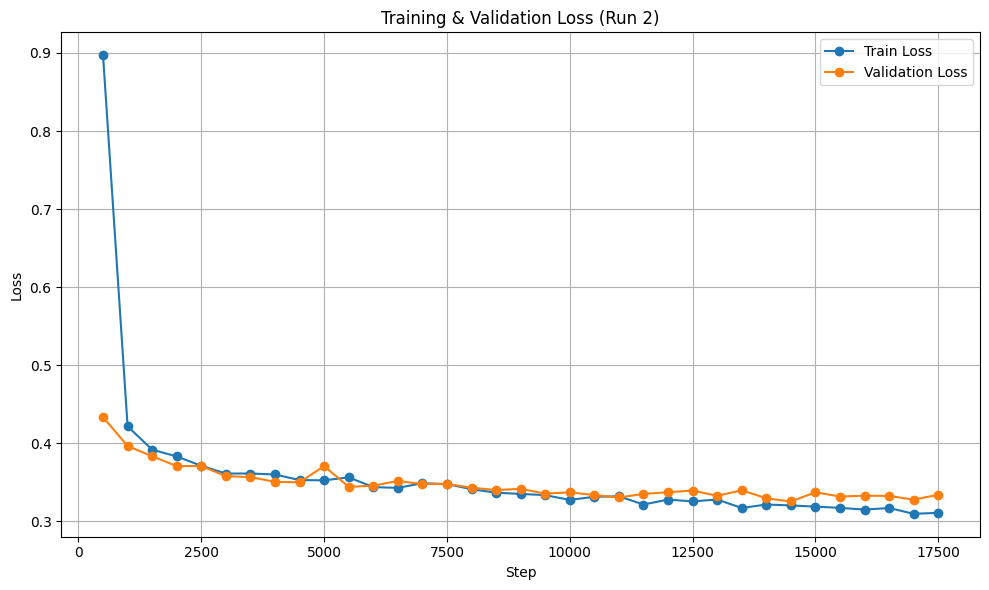

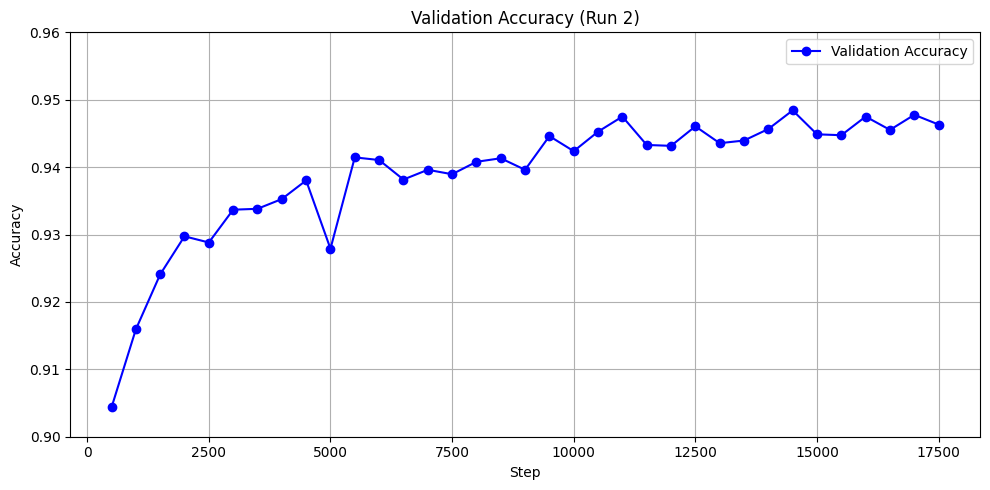

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# 第二次训练日志（17500 步）
data_run2 = [
    [500, 0.897100, 0.433288, 0.904342],
    [1000, 0.421500, 0.396379, 0.915921],
    [1500, 0.391700, 0.383217, 0.924079],
    [2000, 0.383000, 0.370615, 0.929737],
    [2500, 0.371000, 0.370736, 0.928816],
    [3000, 0.361100, 0.357693, 0.933684],
    [3500, 0.361100, 0.356540, 0.933816],
    [4000, 0.359900, 0.350407, 0.935263],
    [4500, 0.352700, 0.349851, 0.938026],
    [5000, 0.352400, 0.370636, 0.927895],
    [5500, 0.356200, 0.344040, 0.941447],
    [6000, 0.343700, 0.345515, 0.941053],
    [6500, 0.342700, 0.351565, 0.938158],
    [7000, 0.348700, 0.347585, 0.939605],
    [7500, 0.347600, 0.347698, 0.938947],
    [8000, 0.341000, 0.342941, 0.940789],
    [8500, 0.336500, 0.339936, 0.941316],
    [9000, 0.335000, 0.341498, 0.939605],
    [9500, 0.333400, 0.335364, 0.944605],
    [10000, 0.327300, 0.336982, 0.942368],
    [10500, 0.331300, 0.333456, 0.945263],
    [11000, 0.331900, 0.330397, 0.947500],
    [11500, 0.321400, 0.335002, 0.943289],
    [12000, 0.327700, 0.337142, 0.943158],
    [12500, 0.325400, 0.339332, 0.946053],
    [13000, 0.327800, 0.332550, 0.943553],
    [13500, 0.316900, 0.339680, 0.943947],
    [14000, 0.321400, 0.329369, 0.945658],
    [14500, 0.320200, 0.325309, 0.948421],
    [15000, 0.318700, 0.337088, 0.944868],
    [15500, 0.317100, 0.331626, 0.944737],
    [16000, 0.314900, 0.332682, 0.947500],
    [16500, 0.316900, 0.332401, 0.945526],
    [17000, 0.309500, 0.327601, 0.947763],
    [17500, 0.310700, 0.333906, 0.946316],
]

# 转为 DataFrame
df2 = pd.DataFrame(data_run2, columns=["Step", "Train Loss", "Val Loss", "Accuracy"])

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(df2["Step"], df2["Train Loss"], label="Train Loss", marker='o')
plt.plot(df2["Step"], df2["Val Loss"], label="Validation Loss", marker='o')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (Run 2)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("run2_loss_curve.png", dpi=300)
plt.show()

# 绘制 Accuracy 曲线
plt.figure(figsize=(10, 5))
plt.plot(df2["Step"], df2["Accuracy"], label="Validation Accuracy", color="blue", marker='o')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.ylim(0.9, 0.96)
plt.title("Validation Accuracy (Run 2)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("run2_accuracy_curve.png", dpi=300)
plt.show()
